<h1 align=center><font size = 5>Predicting Airbnb listing prices in London</font></h1>
<h3 align=center><font size = 3>Álvaro Corrales Cano</font></h3>

This notebook analyses a dataset composed of 83,831 Airbnb listings (in US dollars) from the Greater London area, last scrapped between 10 and 12 July 2019. The dataset can be downloaded in the following link: http://data.insideairbnb.com/united-kingdom/england/london/2019-07-10/data/listings.csv.gz

The notebook is structured in three parts: in the first one, I perform an exploratory analysis of the dataset; in the second one, I transform some of the variables into a format that can be the input of several machine learning models; finally, in the third one I try out some machine learning models to predict a listing's price.

### 0. Load packages and data

Let's start by loading the dataset and packages we will be using throughout the notebook. We will also set the seed that will govern all random initializations.

In [4]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import geopandas as gpd

mpl.style.use(['ggplot'])
%matplotlib inline

directory = '---INSERT DIRECTORY---'
os.chdir(directory)

df = pd.read_csv('listings.csv.gz', 
                   compression='gzip',
                   error_bad_lines=False,
                    low_memory=False)

np.random.seed(1)

### 1. Exploratory Data Analysis

The first thing we do is having a look at the raw data:


In [5]:
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190710134553,2019-07-11,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.15
1,15400,https://www.airbnb.com/rooms/15400,20190710134553,2019-07-11,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.73
2,17402,https://www.airbnb.com/rooms/17402,20190710134553,2019-07-11,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",...,t,f,strict_14_with_grace_period,f,f,14,14,0,0,0.41
3,24328,https://www.airbnb.com/rooms/24328,20190710134553,2019-07-11,Battersea bedroom & office w parking shared ga...,"Artist house, bright high ceiling rooms, priva...",- End of terrace two bedroom house close to So...,"Artist house, bright high ceiling rooms, priva...",family,"- Battersea is a quiet family area, easy acces...",...,f,f,moderate,t,t,1,1,0,0,0.88
4,25023,https://www.airbnb.com/rooms/25023,20190710134553,2019-07-11,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",10 mins walk to Southfields tube and Wimbledon...,"Large, all comforts, 2-bed flat; first floor; ...",none,This is a leafy residential area with excellen...,...,f,f,moderate,f,f,1,1,0,0,0.69


The function head() won't show all of the variables of the dataset, as it is 106 columns wide.

In [6]:
list(df.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


A first glance at price variables (including our target variable, "price") reveals that they are not in any number format. To translate them into numbers, we need to apply some reformating. 

In [7]:
money_features = ['price', 'cleaning_fee', 'weekly_price', 'monthly_price',
                  'security_deposit', 'extra_people']

# Put prices into float format (currently object)
for feature in money_features:
    df[feature] = df[feature].str.replace('$', '')
    df[feature] = df[feature].str.replace(',', '')
    df[feature] = df[feature].astype(float)

Let us now explore the target variable a bit more.

In [8]:
# Summary stats
if df['price'].isnull().any() == False:
    print('Variable "price" has no missing values')
else:
    print('"price" has some missing values')

df['price'].describe() # Very skewed distribution explore with histograms
                       # Some listings seem to be 0

Variable "price" has no missing values


count    83850.000000
mean       121.656303
std        224.900151
min          0.000000
25%         45.000000
50%         81.000000
75%        140.000000
max      13700.000000
Name: price, dtype: float64

Interestingly, there are listings for which price is equal to 0. We will drop these observations, as they cannot even be filled with an estimate based on monthly or weekly price, which appear to always be missing in these cases. 

In [9]:
print(df[['monthly_price', 'weekly_price']][df['price']==0])
df.drop(df[df['price']==0].index, inplace=True)

       monthly_price  weekly_price
22736            NaN           NaN
31030            NaN           NaN
31511            NaN           NaN
34035            NaN           NaN
36471            NaN           NaN
36562            NaN           NaN
37073            NaN           NaN
37177            NaN           NaN
37221            NaN           NaN
37330            NaN           NaN
37344            NaN           NaN
37428            NaN           NaN
37679            NaN           NaN
38631            NaN           NaN
38891            NaN           NaN
39068            NaN           NaN
39335            NaN           NaN
39520            NaN           NaN
39557            NaN           NaN


The distribution of the listing price has a very long tail to the right, as shown in the histogram below. 

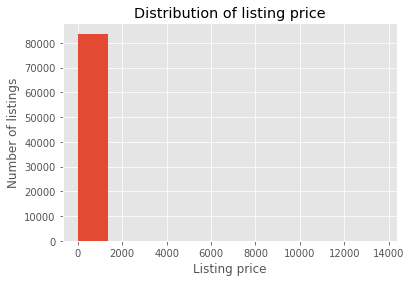

In [10]:
df['price'].hist()

plt.title('Distribution of listing price')
plt.xlabel('Listing price')
plt.ylabel('Number of listings')
plt.show()

A zoom on the "cheapest" prices reveals that most of the observations bunch well below $200:

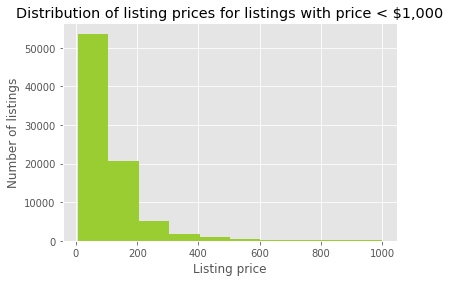

In [19]:
df['price'][df['price']<=1000].hist(color='yellowgreen')

plt.title('Distribution of listing prices for listings with price < $1,000')
plt.xlabel('Listing price')
plt.ylabel('Number of listings')
plt.show()

However, there is also a non-negligible tail of listings with prices above $1000:

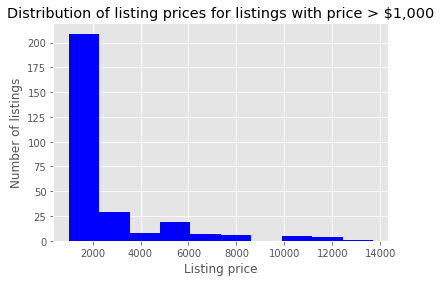

In [11]:
df['price'][df['price']>1000].hist(color='blue') # Long tail of highly-priced listings
plt.title('Distribution of listing prices for listings with price > $1,000')
plt.xlabel('Listing price')
plt.ylabel('Number of listings')
plt.show()

We can shrink the price by applying a logarithmic transformation. This will be useful when we do prediction, as the price will be evaluated in a more compact scale. We can think of the advantage of this transformation in terms of the mapping between two variables, which can be found "more easily" when they are on a similar scale. 

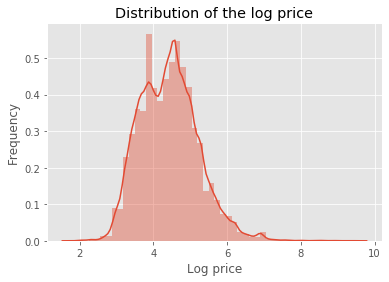

In [12]:
df['log_price'] = np.log(df['price'])

sns.distplot(df['log_price']);
plt.title('Distribution of the log price');
plt.xlabel('Log price');
plt.ylabel('Frequency');

The variables in the dataset have different types. We can evaluate how closely the numerical variables follow the listing price by calculating the correlation between them and the price. The conclusions from the cell below hold if the correlations are taken on the levels of the variables (rather than the logs) and for other types of correlation coefficients.

C:\Users\aldco\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\aldco\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


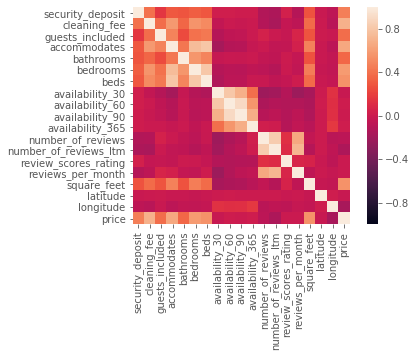

In [14]:
numerical_features1 = ['security_deposit', 'cleaning_fee', 'guests_included', 
                      'accommodates','bathrooms', 'bedrooms', 'beds',
                      'availability_30', 'availability_60', 'availability_90',
                      'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
                      'review_scores_rating', 'reviews_per_month', 'square_feet',
                      'latitude', 'longitude', 'price']

logs = np.log(df[numerical_features1]);

logs_corr = logs.corr(method='pearson');
sns.heatmap(logs_corr, vmin=-1, vmax=1, square=True);

While some variables co-move to a certain degree with the listing price, none of them closely follows it. The most promising relations are those with the security deposit, cleaning fee, guests included, accomodates, number of bathrooms, bedrooms and beds.

On a side note, the correlation of listing price with the other price variables (monthly and weekly) is higher than the ones above (see cell below). Even though they could improve the results of all models that I could possibly run, I decide not to use them from now on. The reason is that I assume that in a real-life scenario when one wants to apply complex modelling to estimate a price, it is unlikely to have information on a more aggregated metric of that price. I could of course be wrong.

In [15]:
print('Correlation of listing and monthly price:', df['price'].corr(df['monthly_price'])) 
print('Correlation of listing and weekly price:', df['price'].corr(df['weekly_price']))

Correlation of listing and monthly price: 0.6168534649121518
Correlation of listing and weekly price: 0.551943089708053


One could reasonably think that listing prices vary substantially across neighbourhoods. This is indeed the case: as shown below, neighbourhoods in the city centre and/or touristic areas, such as Westminster or Camden, have the highest average listing prices. On the contrary, areas in the outskirts, like Bexley or Croydon have more moderate average listing prices. 

In [24]:
print('Average prices by neighbourhood')
print(df['price'].groupby(df['neighbourhood_cleansed']).mean())

Average prices by neighbourhood
neighbourhood_cleansed
Barking and Dagenham       62.537092
Barnet                     85.273304
Bexley                     54.428571
Brent                      89.313511
Bromley                    63.606825
Camden                    144.707558
City of London            175.285408
Croydon                    63.325346
Ealing                     79.531269
Enfield                    62.815166
Greenwich                  81.760961
Hackney                    93.755683
Hammersmith and Fulham    125.385127
Haringey                   85.462436
Harrow                     84.727273
Havering                   72.678261
Hillingdon                 64.248764
Hounslow                   97.060697
Islington                 112.553336
Kensington and Chelsea    212.600478
Kingston upon Thames       78.426497
Lambeth                    92.984603
Lewisham                   86.043909
Merton                    108.935685
Newham                     90.680938
Redbridge           

To help us see more easily the differences presented above, the cell below produces a bar chart of the same information.

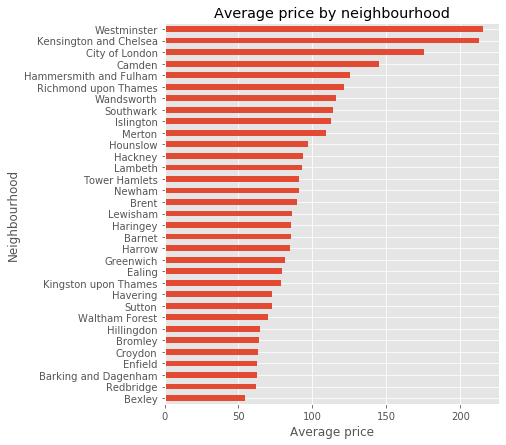

False

In [25]:
df_bar = df[["neighbourhood_cleansed", "price"]]
df_bar = df_bar.pivot_table(index="neighbourhood_cleansed", values="price", 
                            aggfunc = "mean")
df_bar.sort_values("price", ascending = True, inplace = True)

df_bar.plot.barh(legend=None, figsize=(6,7))

plt.title("Average price by neighbourhood")
plt.xlabel("Average price")
plt.ylabel("Neighbourhood")
plt.show()

df["neighbourhood_cleansed"].isnull().any() # False, meaning all observations have a neighbourhood associated

We can plot the above information in a map of London using the library Geopandas. To do so, we will need to import an external map of London boroughs. Note that you may need to install Geopandas to run the three cells below.

In [16]:
boroughs = gpd.read_file("https://skgrange.github.io/www/data/london_boroughs.json")
boroughs.head(10)

,id,name,code,area_hectares,inner_statistical,geometry
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...
1,2,Croydon,E09000008,8649.441,0,(POLYGON ((-0.064021239620113 51.3186376598749...
2,3,Bromley,E09000006,15013.487,0,"(POLYGON ((0.012130938509177 51.2995990596564,..."
3,4,Hounslow,E09000018,5658.541,0,"(POLYGON ((-0.244562394525054 51.48870217634, ..."
4,5,Ealing,E09000009,5554.428,0,(POLYGON ((-0.411832689731467 51.5340838625761...
5,6,Havering,E09000016,11445.735,0,"(POLYGON ((0.1586928320278 51.5121859691707, 0..."
6,7,Hillingdon,E09000017,11570.063,0,"(POLYGON ((-0.40407197286072 51.6131804230767,..."
7,8,Harrow,E09000015,5046.330,0,"(POLYGON ((-0.40407197286072 51.6131804230767,..."
8,9,Brent,E09000005,4323.270,0,(POLYGON ((-0.196568746300418 51.5276540106305...
9,10,Barnet,E09000003,8674.837,0,(POLYGON ((-0.199896404443971 51.6701668576827...


Let us now merge our listings dataset with the map we just downloaded:

In [17]:
df_boroughs = df[["neighbourhood_cleansed", "price"]].copy()
df_boroughs = df_boroughs.pivot_table(index="neighbourhood_cleansed", values="price", 
                            aggfunc = "mean")
df_boroughs.reset_index(level=['neighbourhood_cleansed'], inplace=True)
df_boroughs.rename(columns={'neighbourhood_cleansed':'name'}, inplace=True)

boroughs = boroughs.merge(df_boroughs, on='name')

And now we can proceed to plot the average listing price in the map:

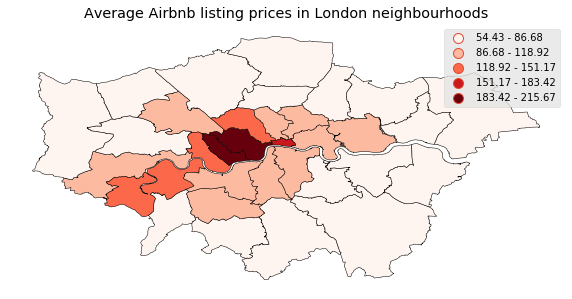

In [19]:
[fig,ax] = plt.subplots(1, figsize=(10, 6));

boroughs.plot(column='price',cmap='Reds', edgecolor='black', linewidth=0.5, 
              legend=True, ax=ax, scheme='equal_interval');
ax.axis('off')
ax.set_title('Average Airbnb listing prices in London neighbourhoods');

Note that the distribution of prices across neighbourhoods is still prety disperse though:

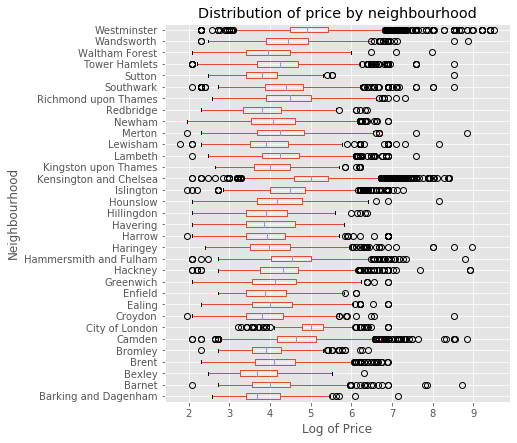

In [20]:
df.boxplot(column='log_price', by='neighbourhood_cleansed', 
           vert=False, figsize=(6,7));
plt.title("Distribution of price by neighbourhood");
plt.suptitle("");
plt.xlabel("Log of Price");
plt.ylabel("Neighbourhood");

We can do a similar analysis by room type. As could be expected, entire properties tend to have higher average prices than rooms.

room_type
Entire home/apt    168.780239
Private room        60.734032
Shared room         83.787755
Name: price, dtype: float64


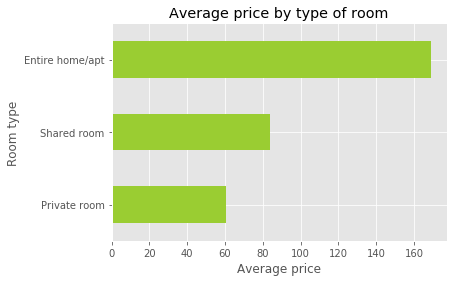

False

In [21]:
print(df['price'].groupby(df['room_type']).mean())

df_bar = df[["room_type", "price"]]
df_bar = df_bar.pivot_table(index="room_type", values="price", aggfunc = "mean")
df_bar.sort_values("price", ascending = True, inplace = True)

df_bar.plot.barh(legend=None, color="yellowgreen")


plt.title("Average price by type of room")
plt.xlabel("Average price")
plt.ylabel("Room type")

plt.show()

df["room_type"].isnull().any() # Great, no missing

There is nonetheless substantial variation, with abundant outliers in all types:

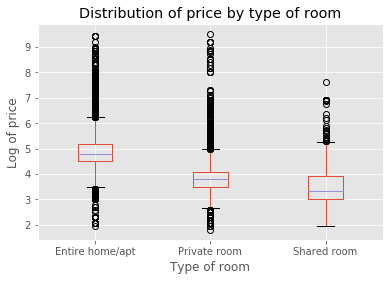

In [22]:
df.boxplot(column='log_price', by='room_type', vert=True);
plt.title("Distribution of price by type of room");
plt.suptitle("");
plt.xlabel("Type of room");
plt.ylabel("Log of price");

In real estate markets, one would expect that surface is highly correlacted with price of the property. However, remember that in the correlation heatmap above, the relation was not that clear. As shown in the regression plot below, on top of some outliers that flatten out the best-fit line, there seems to be a lot of variation for any given surface. 

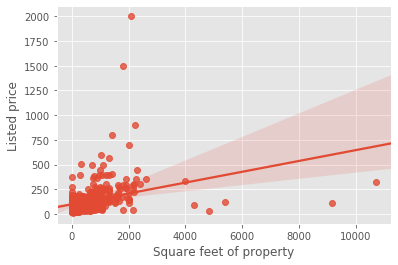

In [23]:
sns.regplot('square_feet', 'price', data=df);
plt.xlabel("Square feet of property");
plt.ylabel("Listed price");


When we apply the smoothing logarithmic function to both variables the relationship looks clearer, even if still affected by some outliers:

C:\Users\aldco\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\aldco\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1942: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


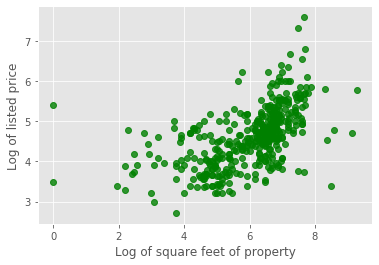

In [24]:
df['log_feet'] = np.log(df['square_feet'])

sns.regplot('log_feet', 'log_price', data=df, color='g');
plt.xlabel("Log of square feet of property");
plt.ylabel("Log of listed price");

Let us now have a look at what kind of properties are rented by neighbourhood. It is not possible to visualise properly all types of properties for all neighbourhoods, so we focus in the top 5 neighbourhoods by number of listings.

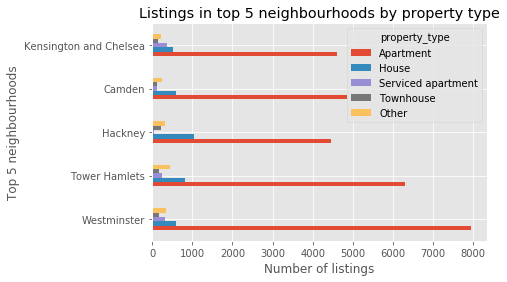

In [25]:
# Set up separately subset of data that we will work with
df_bar = df[["neighbourhood_cleansed", "property_type"]].copy()
df_bar['count'] = 1
df_bar = df_bar.pivot_table(index="neighbourhood_cleansed", columns="property_type", 
                            values="count", aggfunc = "sum")

# Take top 5
df_bar['Total'] = df_bar.sum(axis=1)
df_bar.sort_values("Total", ascending = False, inplace = True)
df_bar = df_bar.head(5).dropna(axis=1)

# Collapse types of properties with few appearances under category "Other"
cols = list(df_bar.columns)
remove = ['Total','Apartment', 'House', 'Serviced apartment', 'Townhouse']
for element in remove:
    cols.remove(element)
cols    
df_bar['Other'] = df_bar[cols].sum(axis=1)
df_bar = df_bar[['Apartment', 'House', 'Serviced apartment', 'Townhouse', 'Other']]

# Plot
df_bar.plot.barh()
plt.ylabel("Top 5 neighbourhoods")
plt.xlabel("Number of listings")
plt.title("Listings in top 5 neighbourhoods by property type")

del df_bar

### 2. Feature Set Up

There are some variables that contain free text, such as "name", "summary", etc. We can extract information from these by vectorising them. The cell below will extract the 1000 most common words (excluding stopwords such as "the", "in" or "is") in the set of all text variables and generate 1000 columns (one for word) with the frequency of each word in the body of text of a given observation.

In [26]:
text_features = ['name', 'summary', 'space', 'description', 'neighborhood_overview',
                 'notes', 'transit', 'access', 'interaction', 'house_rules']

# Incorporate all text fields into just one
text = df[text_features].copy()
text = text.fillna(value=" ")
text['all_text'] = ''
text['all_text'] = text['all_text'].str.cat(text[text_features], sep=" ")
text = text['all_text']
text.isnull().any()

# Vectorise
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=1000)

vector_space_model = word_vectorizer.fit(text.tolist())
text_vars = vector_space_model.fit_transform(text)   # check this is correct
text_vars = text_vars.toarray() # Numpy array format
text_vars_df = pd.DataFrame(data=text_vars) # DataFrame format

Some other features are also text, but they are encoded into a list of closed categories. This is the case of "amenities" and "host_verifications". We will create a set of dummies with each of the amenities and verifications coded into these two variables. 

In [27]:
text_features2 = ['amenities', 'host_verifications']

# Clean list of attributes of characters
def clean_array(l):
    l = l.str.replace('[', '');
    l = l.str.replace(']', '');
    l = l.str.replace('{', '');
    l = l.str.replace('}', '');
    l = l.str.replace("'", '');
    l = l.str.replace('"', '');
    return l;

text_features2_clean = df[text_features2].apply(lambda col: clean_array(col))

# Assign dummies
dummies = [];
for col in text_features2_clean.columns:
    dummy_arrs = text_features2_clean[col].str.get_dummies(sep=',')
    dummy_arrs = dummy_arrs.add_prefix(col + '_')
    dummies.append(dummy_arrs)
    
text_features2_clean = pd.concat(dummies, axis=1)

del dummies, dummy_arrs

Remember that in the previous section we spotted the numerical variables that were the most correlated with price. We will have to fill the missing values in these before we can incorporate them in (most of) our models. 

In [28]:
numerical_features = ['security_deposit', 'cleaning_fee', 'guests_included', 
                      'accommodates','bathrooms', 'bedrooms', 'beds']

# We are going to impute them the median conditional on neighbourhood_cleansed. 
# We could estimate a linear regression an impute the results, but I think this 
# approach should be good enough and is much less complex.

numerical = df[numerical_features].copy()
numerical['neighbourhood_cleansed'] = df['neighbourhood_cleansed']

for col in numerical_features:  
    numerical['median'] = df.groupby(['neighbourhood_cleansed'])[col].transform(np.median)
    numerical[col] = numerical[col].fillna(value=numerical["median"])

numerical = numerical[numerical_features]

numerical.isnull().any()

security_deposit    False
cleaning_fee        False
guests_included     False
accommodates        False
bathrooms           False
bedrooms            False
beds                False
dtype: bool

We also have some categorical variables that we will encode. These include dummy variables such as "is_business_travel_ready", which can take "true" or "false" values enconded as {t, f}.

In [30]:
categorical_features = ['is_business_travel_ready', 'instant_bookable', 'requires_license',
                        'cancellation_policy', 'neighbourhood_cleansed', 'property_type',
                        'room_type', 'bed_type']

# Label Encoding
categorical = df[categorical_features].copy()
for f in categorical.columns:
    if categorical[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(categorical[f].values))
        categorical[f] = lbl.transform(list(categorical[f].values))

Finally, we are going to concatenate all sets of variables that we just preprocessed to form our set of covariates. We are actually going to form two sets of covariates: one will be composed of all types of variables, whereas the other will exclude the set of text variables. The reason is that this last set is made of 1000 columns, which substantially slows down some machine learning algorithms without adding much precision sometimes. 

In [31]:
# Put all covariates but text into a unique dataframe and normalise it
covariates = pd.concat([categorical, numerical, text_features2_clean], axis=1)
X = preprocessing.StandardScaler().fit(covariates).transform(covariates)

covariates.reset_index(inplace=True)

# Now, add text variables 
covariates_plus = pd.concat([covariates, text_vars_df], axis=1)
X_plus = preprocessing.StandardScaler().fit(covariates_plus).transform(covariates_plus)

# Eliminate dataframes we will no longer use
del categorical, numerical, text_features2_clean, text_vars_df, text_vars

### 3. Modelling

Now, we move on to predicting listing prices with different ML models. To do so, we are going to work with the logarithm of the variable "price" in the dataset. As we saw above, this transformation reduces the skew of the data and helps identify relations more clearly. To reverse the transformation and get the predicted price, we would just need to apply the exponential function to our predictions. 

Before getting our hands on the different models let us define our target varible as "y" and split the data set into test and training sets. We will train our models later using cross-validation on the training set, and then see how well they perform in the test set.

In [32]:
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # Test set is 20% of sample
X_plus_train, X_plus_test, y_plus_train, y_plus_test = train_test_split(X_plus, y, test_size = 0.2) # Test set is 20% of sample

Now that we have all of our datasets, let's start trying out some models. Since listing price is a continuous variable, it is natural to start our modelling exercise with a linear regression, the go-to method to work with continous variables in Economics and Data Science. The model can be expressed mathematically as:

$y = \beta X + \epsilon$

where $y$ is an $(n, 1)$ vector containing our target variable, $X$ is an $(n, m)$ matrix with $n$ observations and $m$ independent variables and $\epsilon$ is an error term. In our log-level model with standardised covariates, $\beta$ can be interpreted as the relative variation of $y$ for a unit deviation from the mean in $X$.

We will assess the performance of our models using their R-squared, a metric that measures the proportion of variance of the target variable that is explained by the model. Hence, the R-squared should be bounded within the interval [0, 1]. However, it can sometimes be negative if the model doesn't follow the trend of the data at all.

In [51]:
# Set up and evaluate model in cross-validation sets
linearReg = linear_model.LinearRegression()

scoresLinear = cross_val_score(linearReg, X_train, y_train,
                               cv=5, scoring='r2') # Cross-validate the model across 5 subsets

scoresLinear_plus = cross_val_score(linearReg, X_plus_train, y_plus_train,
                               cv=5, scoring='r2')

print('Cross-validated R-squared of linear model without text covariates:',
      np.mean(scoresLinear))
print('Cross-validated R-squared of linear model with text covariates:',
      np.mean(scoresLinear_plus))
print(" ")

# Test model
linearReg.fit(X_train, y_train)
prediction = linearReg.predict(X_test)

linearReg.fit(X_plus_train, y_plus_train)
prediction_plus = linearReg.predict(X_plus_test)

print('Testing results')
print("R-squared of linear model without text covariates:", r2_score(y_test, prediction))
print("R-squared of linear model with text covariates:", r2_score(y_plus_test, prediction_plus))

Cross-validated R-squared of linear model without text covariates: -1.922913588285639e+23
Cross-validated R-squared of linear model with text covariates: -2.0158795689766505e+24
 
Testing results
R-squared of linear model without text covariates: -1.4026287534137628e+24
R-squared of linear model with text covariates: -1.0265991726294785e+25


The R-squared is zero - even slightly negative. This is probably due to high collinearity issues arising from the high number of covariates of our dataset. We can tackle this problem introducing a regularisation coefficient in our linear regression. The technique that we are going to use is called Ridge regression. This technique penalises large values of the $\beta$ parameter in the linear model described above. We will iterate across several values of the regularisation coefficient, $\alpha$, and see which one performs better before training our final model.

In [33]:
# Select alpha
# We are going to assume that the optimal alpha is the same for both sets of 
# covariates (with and without the variables from the text fields) - The problem 
# is computationally very expensive for the larger set

gsc = GridSearchCV(estimator=linear_model.Ridge(),
        param_grid={'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}, # We test 6 different values for alpha
        cv=5, scoring='r2', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
alpha = grid_result.best_params_['alpha'] # Set the alpha of our model as the one yielding the best results 
                                          # in our dataset

# Evaluate model in cross-validation sets 
ridgeReg = linear_model.Ridge(alpha = alpha)

scoresRidge = cross_val_score(ridgeReg, X_train, y_train,
                               cv=5, scoring='r2')

scoresRidge_plus = cross_val_score(ridgeReg, X_plus_train, y_plus_train,
                               cv=5, scoring='r2')

print('Cross-validation results:')
print('Cross-validated R-squared of Ridge model without text covariates:',
      np.mean(scoresRidge))
print('Cross-validated R-squared of Ridge model with text covariates:',
      np.mean(scoresRidge_plus))
print(" ")

# Test model
ridgeReg.fit(X_train, y_train)
prediction = ridgeReg.predict(X_test)

ridgeReg.fit(X_plus_train, y_plus_train)
prediction_plus = ridgeReg.predict(X_plus_test)

print('Testing results')
print("R-squared of Ridge model without text covariates:", r2_score(y_test, prediction))
print("R-squared of Ridge model with text covariates:", r2_score(y_plus_test, prediction_plus))

Cross-validation results:
Cross-validated R-squared of Ridge model without text covariates: 0.6398541375638348
Cross-validated R-squared of Ridge model with text covariates: 0.7116268406001731
 
Testing results
R-squared of Ridge model without text covariates: 0.6437230753731642
R-squared of Ridge model with text covariates: 0.7244306904745172


Great! We are able to explain between 64% and 72% of the variation of the target variable on average!

There are other methods in the ML toolbox to try to predict a continuous variable, such as Random Forest regression and Gradient Boosting (XGBoost) regression. These are two ensemble methods based on decision trees, and are a very popular baseline in the context of Kaggle competitions and hackathons given their highly predictive ability and robustness to overfit. However, in our particular case and due to the high dimensionality of our data (especially including the text covariates), they are extremely slow to run and do not provide a meaningful improvement over the Ridge regression. I present the code to estimate the two models in the cells below, but bear in mind that each can take HOURS to run.

In [ ]:
#-------------------------
# Random forest regression
#-------------------------
# Perform Grid-Search 
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,10),
        'n_estimators': (10, 50, 100, 1000),
    },
    cv=5, scoring='r2', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

# Fit model
rfr = RandomForestRegressor(max_depth=best_params['max_depth]', 
                            n_estimators=best_params['n_estimators'])

scoresRF = cross_val_score(rfr, X_train, y_train, 
                           cv = 5, scoring='r2')
print('Cross-validated R-squared of Random Forest model without text covariates:',
      np.mean(scoresRF)) # About 70%

In [ ]:
#-------------------------
# XGBoost regression
#-------------------------
# Perform Grid-Search 
gsc = GridSearchCV(estimator=xgb.XGBRegressor(), 
                   param_grid={'max_depth': [3,4,6], 
                                       'learning_rate': [0.1,0.01],
                                       'n_estimators': [500,100]}, verbose=0, n_jobs=-1)

grid_results = gsc.fit(X_train,y_train)
best_params = grid_results.best_params_

# Fit model
gbr = xgb.XGBRegressor(max_depth=best_params['max_depth'], 
                       learning_rate=best_params['learning_rate'],
                       n_estimators=best_params['n_estimators'])

scoresGBR = cross_val_score(gbm, X_train, y_train, 
                           cv = 5, scoring='r2')

Finally, I want to present a third set of methods that could help us predict listing prices: Neural Networks (NN). A NN is a ML algorithm that maps a set of independent variables to the target variable through a set of "hidden" layers of functions that perform sequential transformations of the input. 

Let us first train a NN on the set of covariates without the text fields. Our NN is composed of 6 dense hidden layers using a ReLU activation function. The first layer also computes a regularisation similar in nature to the Ridge regression above. While there can be multiple NN structures that yield a good performance, I have found in this one a good compromise between complexity, running time and predictive power. 

In [44]:
# Define NN
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.Dense(64, activation=tf.nn.relu),   
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.relu)
])

# We keep using R-squared as our performance metric. However, this is not readily coded in the keras package
# that we are using to define the network, so we need to define it manually:
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile model
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=[r_squared])

# Fit to dataset
model.fit(X_train, np.asarray(y_train), epochs=10, batch_size = 64)

# Measure performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('R-squared on training set:', train_acc)
print('R-squared on testing set:', test_acc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/10
67064/67064 [==============================] - 2s 28us/sample - loss: 1.2944 - r_squared: -0.3589
Epoch 2/10
67064/67064 [==============================] - 2s 23us/sample - loss: 0.3377 - r_squared: 0.5980
Epoch 3/10
67064/67064 [==============================] - 2s 23us/sample - loss: 0.2907 - r_squared: 0.6118
Epoch 4/10
67064/67064 [==============================] - 2s 24us/sample - loss: 0.2543 - r_squared: 0.6500
Epoch 5/10
67064/67064 [==============================] - 2s 23us/sample - loss: 0.2549 - r_squared: 0.6449
Epoch 6/10
67064/67064 [==============================] - 2s 23us/sample - loss: 0.2491 - r_squared: 0.6548
Epoch 7/10
67064/67064 [==============================] - 2s 23us/sample - loss: 0.2390 - r_squared: 0.6635
Epoch 8/10
67064/67064 [==============================] - 2s 24us/sample - loss: 0.2330 - r_squared: 0.6691
Epoch 9/10
67064/

Great! Our NN without text covariates yields an R-squared of about 67%, superior to the Ridge regression.

Now, let us fit a similar model including the variables that we got from the text fields:

In [46]:
# Define NN
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.Dense(64, activation=tf.nn.relu),   
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),    
    keras.layers.Dense(1, activation=tf.nn.relu)
])

# Define r-squared
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile model
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=[r_squared])

# Fit model
model.fit(X_plus_train, np.asarray(y_plus_train), epochs=10, batch_size = 64)

train_loss, train_acc = model.evaluate(X_plus_train, y_plus_train)
test_loss, test_acc = model.evaluate(X_plus_test, y_plus_test)
print('R-squared on training set:', train_acc)
print('R-squared on testing set:', test_acc)

Epoch 1/10
67064/67064 [==============================] - 3s 39us/sample - loss: 1.4001 - r_squared: 0.2564
Epoch 2/10
67064/67064 [==============================] - 3s 39us/sample - loss: 0.3495 - r_squared: 0.6735
Epoch 3/10
67064/67064 [==============================] - 3s 37us/sample - loss: 0.2783 - r_squared: 0.7008
Epoch 4/10
67064/67064 [==============================] - 3s 37us/sample - loss: 0.2770 - r_squared: 0.6951
Epoch 5/10
67064/67064 [==============================] - 3s 38us/sample - loss: 0.2584 - r_squared: 0.7074
Epoch 6/10
67064/67064 [==============================] - 3s 37us/sample - loss: 0.2438 - r_squared: 0.7136
Epoch 7/10
67064/67064 [==============================] - 3s 38us/sample - loss: 0.2397 - r_squared: 0.7141
Epoch 8/10
67064/67064 [==============================] - 3s 38us/sample - loss: 0.2386 - r_squared: 0.7175
Epoch 9/10
67064/67064 [==============================] - 3s 39us/sample - loss: 0.2321 - r_squared: 0.7201
Epoch 10/10
16767/16767 [===

The results are slightly above but pretty similar to the Ridge regression. 

This concludes this notebook. I hope you enjoyed!